In [2]:
%load_ext lab_black
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob
import sys

sys.path.append("../src")
import xgboost as xgb

import config as C
from features.UserJoin import (
    UserJoin,
    submit,
    diff,
    plt_month,
    plt_day,
    load_ids,
    info,
    infot,
    f1score,
    gen_day_hol_n,
)

import IPython.display as ipd


from itertools import cycle

sns.set_style("ticks", {"axes.grid": True})
sns.set_theme(style="white", palette=None)
plt.style.use("ggplot")

color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

pd.options.display.max_rows = 50
pd.options.display.min_rows = 50

/opt/conda/envs/miner/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
ds = UserJoin()

# 从这个表可以发现
* n_estimator 100
* lr 0.05
* reg_alpha, reg_labmda .1

In [4]:
res = pd.read_csv("search_result/lgbm_search.csv")
f1 = res.query("total < 50 and right > 34")
f1.groupby(
    [
        "n_estimators",
        "learning_rate",
        "colsample_bytree",
        "reg_alpha",
        "reg_lambda",
    ]
).count().sort_values("gt", ascending=False).head(30)

gt  total  \
n_estimators learning_rate colsample_bytree reg_alpha reg_lambda              
100          0.05          0.3              0.10000   0.10000      4      4   
                           0.8              0.10000   0.10000      4      4   
             0.10          1.0              0.10000   0.10000      4      4   
             0.05          0.4              0.10000   0.10000      4      4   
                           0.6              0.10000   0.10000      4      4   
                           1.0              0.10000   0.10000      4      4   
                                                      0.00001      2      2   
                                            0.00001   0.10000      2      2   
                           0.8              0.00000   0.10000      2      2   
                           0.3              1.00000   0.10000      2      2   
             0.10          1.0              0.30000   0.10000      2      2   
             0.05          1.0              0.50000   0.10000      2      2   
                           0.4              0.90000   0.10000      2      2   
             0.10          1.0              0.00000   0.10000      2      2   
             0.05          0.6              0.70000   0.10000      2      2   
                           0.4              0.30000   0.10000      2      2   
             0.10          1.0              0.10000   1.00000      2      2   
             0.05          1.0              0.10000   0.00100      2      2   
                           0.3              0.90000   0.10000      2      2   
             0.10          1.0              0.50000   0.10000      2      2   
             0.05          0.8              0.00001   0.10000      2      2   
                           1.0              0.00000   0.10000      2      2   
                                            0.10000   0.30000      2      2   
                           0.6              0.10000   0.90000      2      2   
                           0.4              1.00000   0.10000      2      2   
                           0.6              0.30000   0.10000      2      2   
             0.10          1.0              0.10000   0.50000      2      2   
             0.05          0.6              0.10000   0.70000      2      2   
                           0.4              0.10000   0.50000      2      2   
                           1.0              0.10000   0.00000      2      2   

                                                                  right  \
n_estimators learning_rate colsample_bytree reg_alpha reg_lambda          
100          0.05          0.3              0.10000   0.10000         4   
                           0.8              0.10000   0.10000         4   
             0.10          1.0              0.10000   0.10000         4   
             0.05          0.4              0.10000   0.10000         4   
                           0.6              0.10000   0.10000         4   
                           1.0              0.10000   0.10000         4   
                                                      0.00001         2   
                                            0.00001   0.10000         2   
                           0.8              0.00000   0.10000         2   
                           0.3              1.00000   0.10000         2   
             0.10          1.0              0.30000   0.10000         2   
             0.05          1.0              0.50000   0.10000         2   
                           0.4              0.90000   0.10000         2   
             0.10          1.0              0.00000   0.10000         2   
             0.05          0.6              0.70000   0.10000         2   
                           0.4              0.30000   0.10000         2   
             0.10          1.0              0.10000   1.00000         2   
             0.05          1.0              0.10000   0.00100         2   
                           0.3       

# 重新按参数训练（之前参数空间太大了）

In [5]:
res = pd.read_csv("search_result/lgbm_search_100.csv")
res.sort_values("f1score", ascending=False).head(10)

,n_estimators,learning_rate,colsample_bytree,reg_alpha,reg_lambda,gt,right,wrong,total,f1score,ids
27,100,0.05,0.4,0.1,0.1,5,36,11,47,0.928376,"{2496032641, 179458306, 2817362052, 2212416005..."
5,100,0.05,0.3,0.1,0.1,5,36,11,47,0.928376,"{2496032641, 179458306, 2817362052, 2212416005..."
93,100,0.05,1.0,0.1,0.1,5,36,11,47,0.928376,"{2496032641, 179458306, 2817362052, 2212416005..."
71,100,0.05,0.8,0.1,0.1,5,35,10,45,0.926634,"{2496032641, 179458306, 2817362052, 2212416005..."
49,100,0.05,0.6,0.1,0.1,5,35,10,45,0.926634,"{2496032641, 179458306, 2817362052, 2212416005..."
51,100,0.05,0.6,0.1,0.1,7,29,6,35,0.902550,"{2496032641, 179458306, 2212416005, 2741872006..."
73,100,0.05,0.8,0.1,0.1,7,29,6,35,0.902550,"{2496032641, 179458306, 2212416005, 2741872006..."
72,100,0.05,0.8,0.1,0.1,6,30,8,38,0.899756,"{2496032641, 179458306, 2212416005, 2741872006..."
50,100,0.05,0.6,0.1,0.1,6,30,8,38,0.899756,"{2496032641, 179458306, 2212416005, 2741872006..."
28,100,0.05,0.4,0.1,0.1,6,31,10,41,0.897175,"{2496032641, 179458306, 2212416005, 2741872006..."


In [6]:
res = pd.read_csv("search_result/lgbm_search_200.csv")
res.sort_values("f1score", ascending=False).head(10)

,n_estimators,learning_rate,colsample_bytree,reg_alpha,reg_lambda,gt,right,wrong,total,f1score
27,200,0.05,0.4,0.1,0.1,5,36,16,52,0.904217
72,200,0.05,0.8,0.1,0.1,6,33,12,45,0.902178
6,200,0.05,0.3,0.1,0.1,6,33,12,45,0.902178
28,200,0.05,0.4,0.1,0.1,6,33,12,45,0.902178
5,200,0.05,0.3,0.1,0.1,5,36,17,53,0.899707
93,200,0.05,1.0,0.1,0.1,5,36,17,53,0.899707
71,200,0.05,0.8,0.1,0.1,5,36,17,53,0.899707
49,200,0.05,0.6,0.1,0.1,5,36,17,53,0.899707
7,200,0.05,0.3,0.1,0.1,7,31,10,41,0.897175
73,200,0.05,0.8,0.1,0.1,7,31,10,41,0.897175


In [7]:
res = pd.read_csv("search_result/lgbm_search_300.csv")
res.sort_values("f1score", ascending=False).head(10)

,n_estimators,learning_rate,colsample_bytree,reg_alpha,reg_lambda,gt,right,wrong,total,f1score
94,300,0.05,1.0,0.1,0.1,6,34,11,45,0.914406
50,300,0.05,0.6,0.1,0.1,6,34,11,45,0.914406
72,300,0.05,0.8,0.1,0.1,6,34,11,45,0.914406
95,300,0.05,1.0,0.1,0.1,7,33,11,44,0.907163
51,300,0.05,0.6,0.1,0.1,7,33,11,44,0.907163
29,300,0.05,0.4,0.1,0.1,7,33,11,44,0.907163
73,300,0.05,0.8,0.1,0.1,7,33,11,44,0.907163
28,300,0.05,0.4,0.1,0.1,6,33,12,45,0.902178
6,300,0.05,0.3,0.1,0.1,6,33,12,45,0.902178
5,300,0.05,0.3,0.1,0.1,5,36,17,53,0.899707


In [8]:
res = pd.read_csv("search_result/lgbm_search_400.csv")
res.sort_values("f1score", ascending=False).head(10)

,n_estimators,learning_rate,colsample_bytree,reg_alpha,reg_lambda,gt,right,wrong,total,f1score
8,400,0.05,0.3,0.1,0.1,8,32,11,43,0.899739
7,400,0.05,0.3,0.1,0.1,7,34,15,49,0.895055
74,400,0.05,0.8,0.1,0.1,8,32,13,45,0.889951
96,400,0.05,1.0,0.1,0.1,8,32,13,45,0.889951
52,400,0.05,0.6,0.1,0.1,8,32,13,45,0.889951
51,400,0.05,0.6,0.1,0.1,7,34,18,52,0.881680
95,400,0.05,1.0,0.1,0.1,7,34,18,52,0.881680
73,400,0.05,0.8,0.1,0.1,7,34,18,52,0.881680
30,400,0.05,0.4,0.1,0.1,8,32,15,47,0.880626
6,400,0.05,0.3,0.1,0.1,6,34,19,53,0.877419


In [9]:
res = pd.read_csv("search_result/lgbm_search_90.csv")
res.sort_values("f1score", ascending=False).head(10)

,n_estimators,learning_rate,colsample_bytree,reg_alpha,reg_lambda,gt,right,wrong,total,f1score,ids
27,90,0.05,0.4,0.1,0.1,5,35,9,44,0.931919,"{2496032641, 179458306, 2817362052, 2212416005..."
5,90,0.05,0.3,0.1,0.1,5,36,11,47,0.928376,"{2496032641, 179458306, 2817362052, 2212416005..."
49,90,0.05,0.6,0.1,0.1,5,35,10,45,0.926634,"{2496032641, 179458306, 2817362052, 2212416005..."
93,90,0.05,1.0,0.1,0.1,5,35,10,45,0.926634,"{2496032641, 179458306, 2817362052, 2212416005..."
71,90,0.05,0.8,0.1,0.1,5,35,10,45,0.926634,"{2496032641, 179458306, 2817362052, 2212416005..."
51,90,0.05,0.6,0.1,0.1,7,29,6,35,0.902550,"{2496032641, 179458306, 2212416005, 2741872006..."
73,90,0.05,0.8,0.1,0.1,7,29,6,35,0.902550,"{2496032641, 179458306, 2212416005, 2741872006..."
95,90,0.05,1.0,0.1,0.1,7,29,6,35,0.902550,"{2496032641, 179458306, 2212416005, 2741872006..."
29,90,0.05,0.4,0.1,0.1,7,29,6,35,0.902550,"{2496032641, 179458306, 2212416005, 2741872006..."
50,90,0.05,0.6,0.1,0.1,6,30,8,38,0.899756,"{2496032641, 179458306, 2212416005, 2741872006..."


In [10]:
res = pd.read_csv("search_result/lgbm_search_75.csv")
res.sort_values("f1score", ascending=False).head(10)

,n_estimators,learning_rate,colsample_bytree,reg_alpha,reg_lambda,gt,right,wrong,total,f1score,ids
27,75,0.05,0.4,0.1,0.1,5,35,9,44,0.931919,"{2496032641, 179458306, 2817362052, 2212416005..."
5,75,0.05,0.3,0.1,0.1,5,35,9,44,0.931919,"{2496032641, 179458306, 2817362052, 2212416005..."
49,75,0.05,0.6,0.1,0.1,5,35,10,45,0.926634,"{2496032641, 179458306, 2817362052, 2212416005..."
71,75,0.05,0.8,0.1,0.1,5,35,10,45,0.926634,"{2496032641, 179458306, 2817362052, 2212416005..."
93,75,0.05,1.0,0.1,0.1,5,35,10,45,0.926634,"{2496032641, 179458306, 2817362052, 2212416005..."
95,75,0.05,1.0,0.1,0.1,7,29,6,35,0.902550,"{2496032641, 179458306, 2212416005, 2741872006..."
51,75,0.05,0.6,0.1,0.1,7,29,6,35,0.902550,"{2496032641, 179458306, 2212416005, 2741872006..."
29,75,0.05,0.4,0.1,0.1,7,29,6,35,0.902550,"{2496032641, 179458306, 2212416005, 2741872006..."
7,75,0.05,0.3,0.1,0.1,7,29,6,35,0.902550,"{2496032641, 179458306, 2212416005, 2741872006..."
73,75,0.05,0.8,0.1,0.1,7,29,6,35,0.902550,"{2496032641, 179458306, 2212416005, 2741872006..."


In [11]:
res = pd.read_csv("search_result/lgbm_search_75_85.csv")
res.sort_values("f1score", ascending=False).head(10)

,n_estimators,learning_rate,colsample_bytree,reg_alpha,reg_lambda,gt,right,wrong,total,f1score,ids
16967,75,0.1,0.4,0.10,0.000,5,36,10,46,0.933556,"{2496032641, 179458306, 2817362052, 2212416005..."
18375,75,0.1,0.8,0.01,0.010,5,36,10,46,0.933556,"{2496032641, 179458306, 2817362052, 2212416005..."
16813,75,0.1,0.4,0.01,0.100,5,36,10,46,0.933556,"{2496032641, 179458306, 2817362052, 2212416005..."
18771,75,0.1,0.8,0.50,0.010,5,36,10,46,0.933556,"{2496032641, 179458306, 2817362052, 2212416005..."
18529,75,0.1,0.8,0.10,0.100,5,36,10,46,0.933556,"{2496032641, 179458306, 2817362052, 2212416005..."
17231,75,0.1,0.4,0.50,0.000,5,36,10,46,0.933556,"{2496032641, 179458306, 2817362052, 2212416005..."
17891,75,0.1,0.6,0.00,0.000,5,36,10,46,0.933556,"{2496032641, 179458306, 2817362052, 2212416005..."
16769,75,0.1,0.4,0.01,0.001,5,36,10,46,0.933556,"{2496032641, 179458306, 2817362052, 2212416005..."
16945,75,0.1,0.4,0.10,0.100,5,36,10,46,0.933556,"{2496032641, 179458306, 2817362052, 2212416005..."
17121,75,0.1,0.4,0.00,0.500,5,36,10,46,0.933556,"{2496032641, 179458306, 2817362052, 2212416005..."


# 增加树并没有什么好的效果，减少还有一点点提升

看看现在 FP 是哪些 id，是否能通过引入一些特征来解决（因为现在还没有用到日数据）

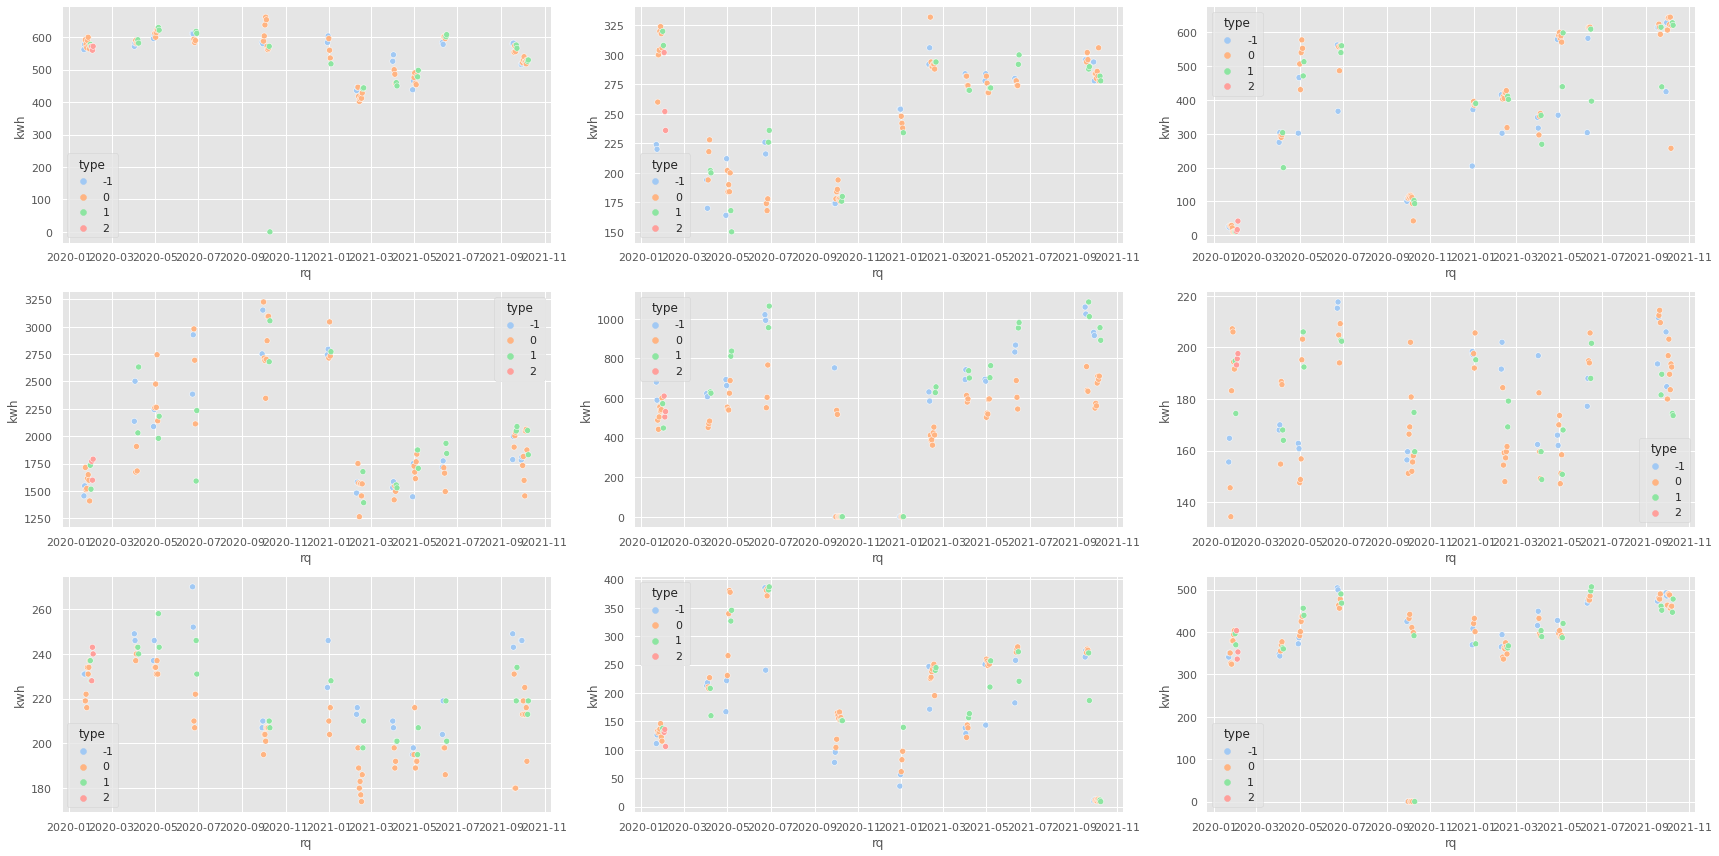

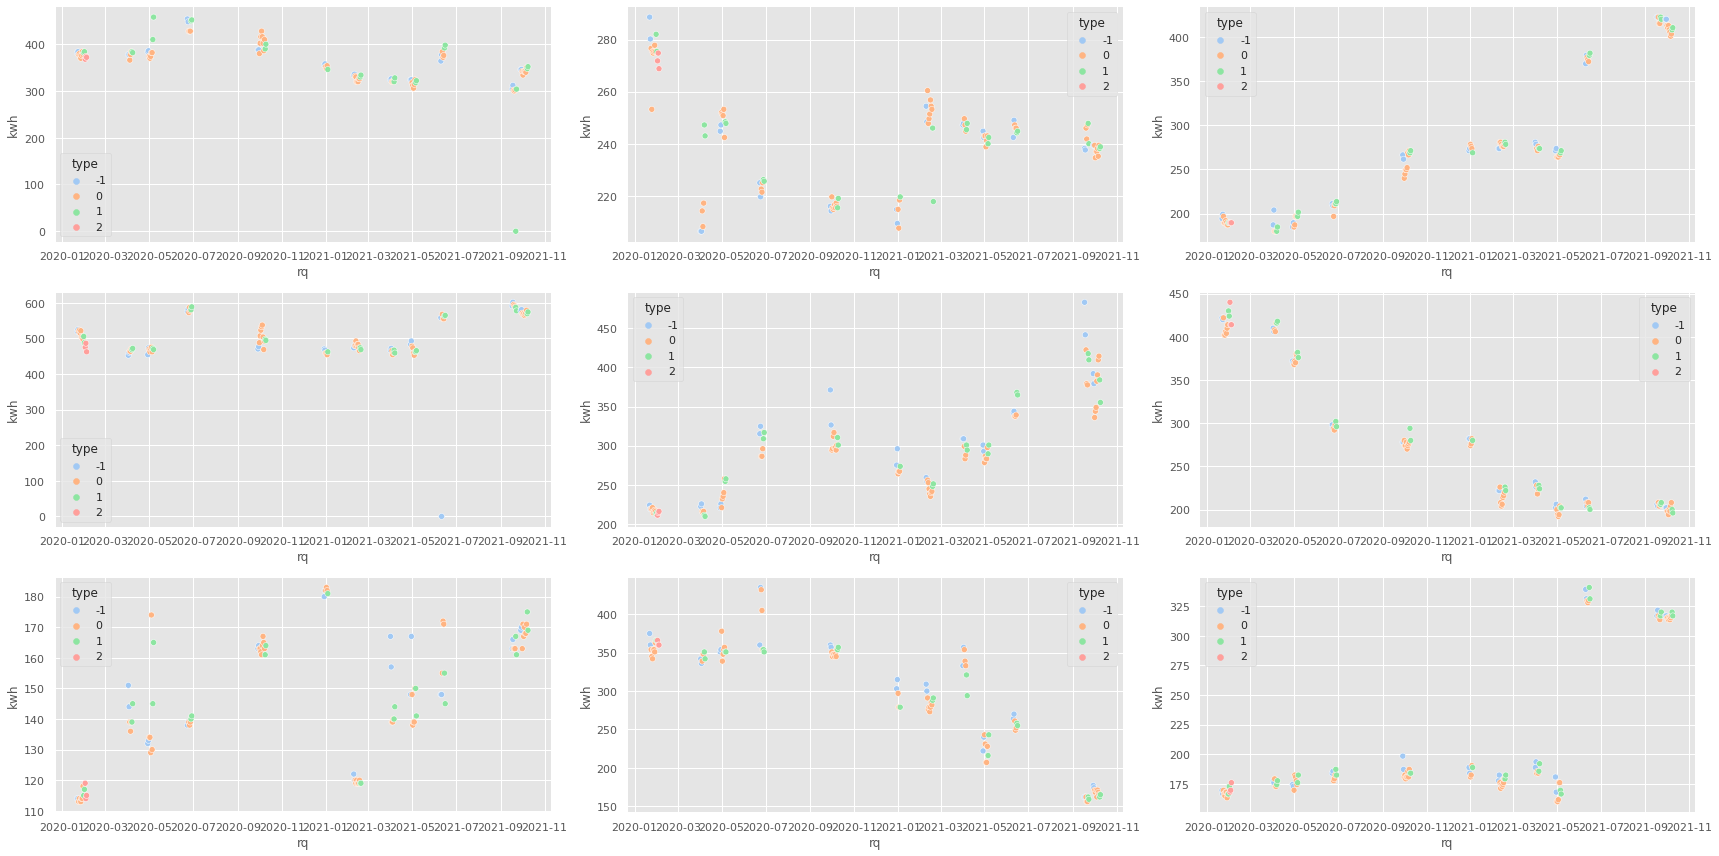

In [10]:
res = pd.read_csv("lgbm_search_75.csv")
ids = res.sort_values("f1score", ascending=False).iloc[0].ids
ids = eval(ids)
miner = ids & C.true_ids
normal = list(ids - C.true_ids)


def plt_day(ids):
    fig, axs = plt.subplots(3, 3, figsize=(24, 12))
    for i, id in enumerate(ids):
        sns.scatterplot(
            data=ds.day.query("id == @id"),
            x="rq",
            y="kwh",
            hue="type",
            palette="pastel",
            # palette="hls",
            ax=axs[int(i / 3), i % 3],
        )
    plt.tight_layout()
    plt.show()


plt_day(normal)
plt_day(list(miner)[:9])

In [19]:
# def plt_month(ids):
#     fig, axs = plt.subplots(3, 3, figsize=(24, 12))
#     for i, id in enumerate(ids):
#         sns.lineplot(
#             data=ds.month.query("id == @id").reset_index(),
#             x="ym",
#             y="pq_z",
#             # palette="pastel",
#             # palette="hls",
#             ax=axs[int(i / 3), i % 3],
#         )
#     plt.tight_layout()
#     plt.show()


# print("label: 0")
# plt_month(normal)
# print("label: 1")
# plt_month(list(miner)[:9])

In [65]:
[i for i in t.columns if "cv" in i]

['daycv',
 'daycv_holiday_mean_1',
 'daycv_holiday_mean_0',
 'daycv_holiday_std_1',
 'daycv_holiday_std_0',
 'daycv_holiday_diff',
 'kwh_holiday_cv',
 'kwh_cal_holiday_cv',
 'kwh_pap_r2_holiday_cv',
 'kwh_pap_r3_holiday_cv',
 'kwh_pap_r4_holiday_cv',
 'kwh_workday_cv',
 'kwh_cal_workday_cv',
 'kwh_pap_r2_workday_cv',
 'kwh_pap_r3_workday_cv',
 'kwh_pap_r4_workday_cv',
 'kwh_cv',
 'kwh_cal_cv',
 'kwh_pap_r2_cv',
 'kwh_pap_r3_cv',
 'kwh_pap_r4_cv',
 'monthcv',
 'cv2_all',
 'cv3_all',
 'cv4_all',
 'cv_all',
 'cv2_holiday',
 'cv3_holiday',
 'cv4_holiday',
 'cv_holiday',
 'cv2_workday',
 'cv3_workday',
 'cv4_workday',
 'cv_workday']

# 从图里看出还是有比较明显区别的，看看cv值

In [94]:
from IPython.display import display

t = ds.train.query("id.isin(@ids)")
display(
    t.groupby("isminer")[
        [
            "kwh_cal_cv",
            "kwh_pap_r4_cv",
            "kwh_cal_workday_cv",
            "kwh_pap_r4_workday_cv",
            "kwh_cal_holiday_cv",
            "kwh_pap_r4_holiday_cv",
        ]
    ]
    .mean()
    .style.background_gradient()
)
t.groupby(["isminer", "id"])[
    [
        "kwh_cal_cv",
        "kwh_pap_r4_cv",
        "kwh_cal_workday_cv",
        "kwh_pap_r4_workday_cv",
        "kwh_cal_holiday_cv",
        "kwh_pap_r4_holiday_cv",
    ]
].last().style.background_gradient()

,kwh_cal_cv,kwh_pap_r4_cv,kwh_cal_workday_cv,kwh_pap_r4_workday_cv,kwh_cal_holiday_cv,kwh_pap_r4_holiday_cv
isminer,,,,,,
miner,0.219524,0.225647,0.220942,0.227607,0.216019,0.221851
normal,0.298456,0.326049,0.285003,0.320203,0.301606,0.327926


cv 值是要大一点，但是不是那么的清晰…  需要想一下怎么把这个数据加到模型里

# `2_4_holiday_diff` 和 `daycv_holiday_diff` 对下一步细分有帮助
这里整理一下特征，太多了名字分不清

In [98]:
import re

t = ds.train.query("id.isin(@ids)")

# holiday_diff 所有节假日的平均 - 所有非假日的平均
diff_cols = [i for i in t.columns if "holiday_diff" in i]


# 所有节假日混起来的 cv
col1 = [i for i in t.columns if "holiday_cv" in i]
print(col1)

# 所有工作日混起来的 cv
col2 = [i for i in t.columns if "workday_cv" in i]
print(col2)
# 所有日子混起来的 cv
col3 = [
    i for i in t.columns if "_cv" in i and "holiday" not in i and "workday" not in i
]
print(col3)

# _all 每个节假日的所有数据分别计算cv
col4 = [i for i in t.columns if "_all" in i]
print(col4)

# _workday 每个节假日期间的工作日数据分别计算cv
col5 = [i for i in t.columns if bool(re.search("_workday$", i))]
print(col5)

# _holiday 每个节假日期间的休息日数据分别计算cv
col6 = [i for i in t.columns if bool(re.search("_holiday$", i))]
print(col6)

# (
#     set([i for i in t.columns if "cv" in i])
#     - set(col1)
#     - set(col2)
#     - set(col3)
#     - set(col4)
#     - set(col5)
#     - set(col6)
# )

['kwh_holiday_cv', 'kwh_cal_holiday_cv', 'kwh_pap_r2_holiday_cv', 'kwh_pap_r3_holiday_cv', 'kwh_pap_r4_holiday_cv']
['kwh_workday_cv', 'kwh_cal_workday_cv', 'kwh_pap_r2_workday_cv', 'kwh_pap_r3_workday_cv', 'kwh_pap_r4_workday_cv']
['kwh_cv', 'kwh_cal_cv', 'kwh_pap_r2_cv', 'kwh_pap_r3_cv', 'kwh_pap_r4_cv']
['cv2_all', 'cv3_all', 'cv4_all', 'cv_all']
['cv2_workday', 'cv3_workday', 'cv4_workday', 'cv_workday']
['cv2_holiday', 'cv3_holiday', 'cv4_holiday', 'cv_holiday']


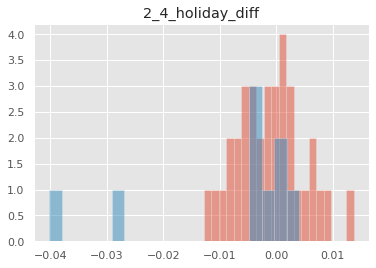

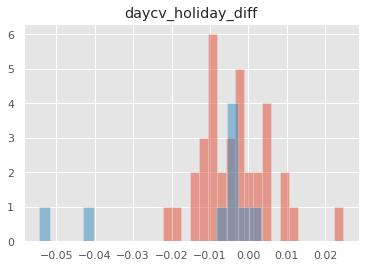

In [99]:
t = ds.train.query("id.isin(@ids)")
# for i in diff_cols:
# 重点看下这两个
for i in ["2_4_holiday_diff", "daycv_holiday_diff"]:
    if "kwh" in i:
        continue
    t.groupby("isminer")[i].hist(alpha=0.5, bins=20)
    plt.title(i)
    plt.show()